In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from gatspy import datasets
from scipy.interpolate import interp1d
import sys
import pickle
from photutils import create_matching_kernel
from astropy.convolution import convolve
from photutils import TopHatWindow
import cv2
from skimage import transform as tf

In [2]:
save_path = "chapter2_plots/"
plot_fontsize = 18
plot_figsize = (15, 6)

# DECam Filter respons

In [3]:
filter_respons = pd.read_csv('data/decam_bands.txt', delim_whitespace=True)

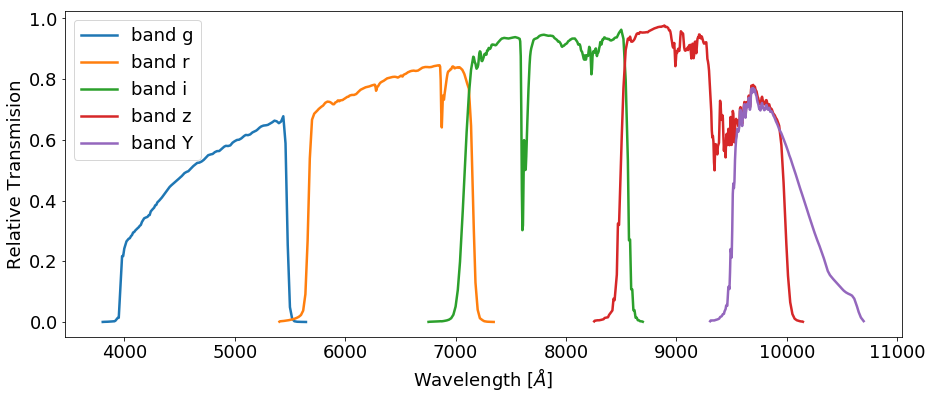

In [4]:
DECam_bands = ['g', 'r', 'i', 'z', 'Y']
wavelength = filter_respons['LAMBDA']
plt.figure(figsize=plot_figsize)
for i, band in enumerate(DECam_bands):
    non_zero_mask = np.where(filter_respons[band].values > 0)[0]
    plt.plot(wavelength[non_zero_mask], filter_respons[band].values[non_zero_mask], lw=2.5, label="band "+band)
plt.legend(fontsize=plot_fontsize)
plt.tick_params(axis='both', which='major', labelsize=plot_fontsize)
plt.xlabel("Wavelength [$\AA$]", fontsize=plot_fontsize)
plt.ylabel("Relative Transmision", fontsize=plot_fontsize)
plt.savefig(save_path+"filter_respons.pdf", bbox_inches = 'tight')
plt.show()

# Supernova spectra and redshift

In [5]:
def apply_redshift(emited_lambdas, emited_spectra, redshift=0.5):
    observed_lambdas = (1+redshift)*emited_lambdas
    tau = 0.00211*(1+redshift)**(3.7)
    observed_spectra = emited_spectra*np.exp(-tau)# https://academic.oup.com/mnras/article/365/3/807/968285
    return observed_lambdas, observed_spectra

In [6]:
# Data from https://www.nhn.ou.edu/cgi-bin/cgiwrap/~suspect/search.cgi 2006bp
spectra_data = pd.read_csv('data/Quimby_2007_2006bp.txt', delim_whitespace=True)
observerd_wavelength = spectra_data["wavelength"].values
spectra = spectra_data["spectra"].values

In [7]:
## Applying redshift
cmap = matplotlib.cm.get_cmap('plasma')
redshift = [0.0, 0.3, 0.5, 1.0, 1.5, 2.0, 3.0]
colors = np.linspace(start=0, stop=0.75, num=len(redshift))
redshifted_w = []
redshifted_c = []
color_list = []
for i, z in enumerate(redshift):
    redshifted_wavelength, redshifted_spectra = apply_redshift(observerd_wavelength, spectra, redshift=z)
    redshifted_w.append(redshifted_wavelength)
    redshifted_c.append(redshifted_spectra)
    color_list.append(cmap(colors[i]))

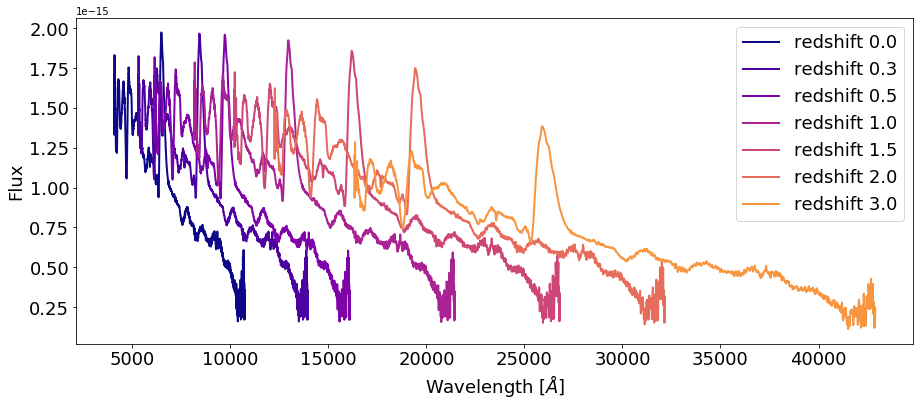

In [8]:
plt.figure(figsize=plot_figsize)
for i, z in enumerate(redshift):
    plt.plot(redshifted_w[i], redshifted_c[i], color=color_list[i], lw=2, label="redshift "+str(z))
plt.legend(fontsize=plot_fontsize)
plt.tick_params(axis='both', which='major', labelsize=plot_fontsize)
plt.xlabel("Wavelength [$\AA$]", fontsize=plot_fontsize)
plt.ylabel("Flux", fontsize=plot_fontsize)
plt.savefig(save_path+"redshift_effect.pdf",  bbox_inches = 'tight')
plt.show()

# Periodic light curves plots

### RR Lyrae

In [9]:
periodic_lightcurves = {}

basic_cadence = np.linspace(start=0, stop=2, num=5)
simulated_cadence = {"g":[], "r":[], "i":[]}
for band in ["g","r","i"]:
    for i in range(10):
        simulated_cadence[band].append(basic_cadence + i*3 + np.random.normal(scale = 0.3, size=(len(basic_cadence,))))
    simulated_cadence[band] = np.concatenate(simulated_cadence[band])
    simulated_cadence[band] = np.sort(simulated_cadence[band])
#plt.scatter(simulated_cadence[band], np.ones(shape=(len(simulated_cadence[band],) )))
#plt.show()

rrlyrae = datasets.fetch_rrlyrae()
lcid = rrlyrae.ids[0]

# Set up the generated lightcurve
gen = datasets.RRLyraeGenerated(lcid, random_state=0)

#fig, ax = plt.subplots(figsize=(12,7))
periodic_lightcurves["RR Lyra"] = {}
for shot, band in enumerate(["g","r","i"]):
    dense_cadence = np.arange(start=0, stop=np.amax(simulated_cadence[band]), step=0.01)
    mag_gen = gen.generated(band, simulated_cadence[band], 0.05)
    dense_mag = gen.generated(band, dense_cadence, 0)
    period = gen.period
    phase = ((simulated_cadence[band]) / period) % 1
    dmag = np.clip(np.random.normal(scale = 0.05, size=(len(mag_gen),)), a_min=0.03, a_max=None)
    
    print(dense_cadence.shape,
    mag_gen.shape,
    dense_mag.shape,
          phase.shape)
    
    #errorbar = ax.errorbar(phase, mag_gen, dmag, fmt='.', label=band)
    #color = errorbar.lines[0].get_color()
    periodic_lightcurves["RR Lyra"][band] = {"period": period, "mag": np.copy(mag_gen), "error_mag": np.copy(dmag), 
                                              "simulated_cadence": np.copy(simulated_cadence[band]), "dense_cadence": np.copy(dense_cadence),
                                              "dense_mag": np.copy(dense_mag)}
    
#ax.set(xlabel='phase', ylabel='mag')
#ax.invert_yaxis()
#ax.legend(loc='lower center', ncol=5, numpoints=1)
#plt.show()

(2895,) (50,) (2895,) (50,)
(2918,) (50,) (2918,) (50,)
(2877,) (50,) (2877,) (50,)


### Cepheids

In [10]:
cepheids_path = "../HiTS_simulations/lightcurve_sampling/lc_data/cepheid_gps.pkl"
lc_gps = np.load(cepheids_path, encoding="latin1")

/usr/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
lc_id = 7
period = lc_gps["stats"][lc_id]["g"][2]
gp = lc_gps["gps"][lc_id]
stats = lc_gps["stats"][lc_id]

periodic_lightcurves["Cepheid"] = {}
for band in ["g","r","i"]:
    phase = np.mod(simulated_cadence[band], period)*(1.0/period)
    lc = gp[band].predict(X=phase[:, np.newaxis])
    lc = lc*stats[band][1]+stats[band][0] + np.random.normal(scale = 0.1, size=(len(lc),))
    dmag = np.clip(np.abs(np.random.normal(scale = 0.05, size=(len(mag_gen),))), a_min=0.03, a_max=None)
    #plt.scatter(np.concatenate([phase, phase+1]), np.concatenate([lc, lc]), label=band)
    
    dense_cadence = np.arange(start=0, stop=np.amax(simulated_cadence[band]), step=0.01)
    dense_phase = np.mod(dense_cadence, period)*(1.0/period)
    dense_lc = gp[band].predict(X=dense_phase[:, np.newaxis])
    dense_lc = dense_lc*stats[band][1]+stats[band][0]
    
    periodic_lightcurves["Cepheid"][band] = {"period": period, "mag": np.copy(lc), "error_mag": np.copy(dmag), 
                                              "simulated_cadence": np.copy(simulated_cadence[band]), "dense_cadence": np.copy(dense_cadence),
                                              "dense_mag": np.copy(dense_lc)}
    
#plt.gca().invert_yaxis()
#plt.show()

### Eclipsing binaries

In [12]:
eb_path = "../HiTS_simulations/lightcurve_sampling/lc_data/eb_templates.pkl"
templates = np.load(eb_path)
av_bands = list(templates[0].keys())[2:]
interpolations = []
for temp in templates:
    aux_dict = {}
    g_band_average = np.mean(temp["g"])
    for band in ["g","r","i"]:
        x = np.append(temp["phase"], 1)
        y = np.append(temp[band], temp[band][0])
        y = 2*g_band_average - y
        aux_dict[band] = interp1d(x, y, kind='cubic')
    interpolations.append(aux_dict)

lc_id = 4
period = templates[lc_id]["Period"]
interpolation = interpolations[lc_id]
template_g_average = np.mean(templates[lc_id]["g"])

mag_values = 19.0
periodic_lightcurves["Eclipsing Binary"] = {}

for band in ["g","r","i"]:
    phase = np.mod(simulated_cadence[band], period)*(1.0/period)
    lc = interpolation[band](phase)
    mag = lc + (mag_values-1) + np.random.normal(scale = 0.03, size=(len(lc),))
    #plt.scatter(phase, mag)
    dense_cadence = np.arange(start=0, stop=np.amax(simulated_cadence[band]), step=0.01)
    dense_phase = np.mod(dense_cadence, period)*(1.0/period)
    dense_lc = interpolation[band](dense_phase) + mag_values - 1
    dmag = np.clip(np.abs(np.random.normal(scale = 0.05, size=(len(mag_gen),))), a_min=0.03, a_max=None)
    
    periodic_lightcurves["Eclipsing Binary"][band] = {"period": period, "mag": np.copy(mag), "error_mag": np.copy(dmag), 
                                              "simulated_cadence": np.copy(simulated_cadence[band]), "dense_cadence": np.copy(dense_cadence),
                                              "dense_mag": np.copy(dense_lc)}
    
#plt.gca().invert_yaxis()
#plt.show()

RR Lyra
RR Lyra
RR Lyra
Cepheid
Cepheid
Cepheid
Eclipsing Binary
Eclipsing Binary
Eclipsing Binary


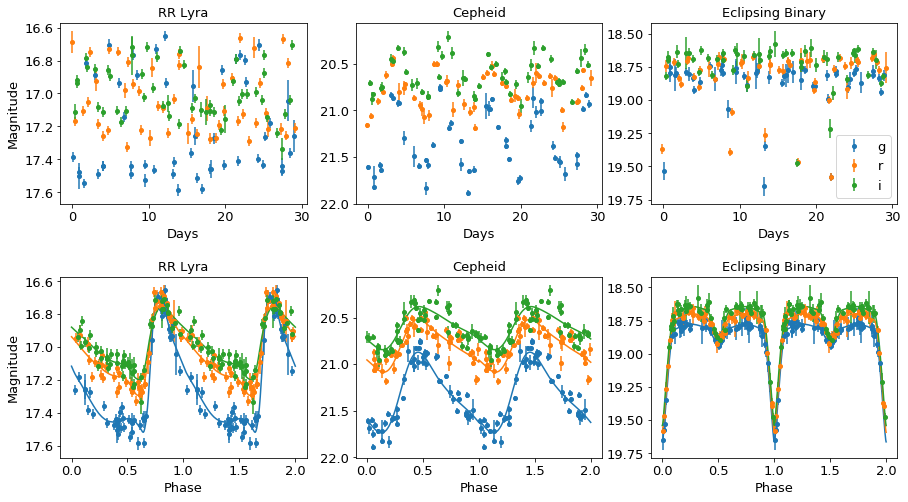

In [21]:
f, ax = plt.subplots(2,3,figsize=(15,8))
#print(periodic_lightcurves["Cepheid"].keys())
key_names = list(periodic_lightcurves.keys())
reduce_fontsize = 5
plt.subplots_adjust(hspace=0.4)

for i in range(3):
    for j, band in enumerate(["g","r","i"]):
        print(key_names[i])
        lc_data = periodic_lightcurves[key_names[i]][band]
        period = lc_data["period"]
        sim_cadence = lc_data["simulated_cadence"]
        den_cadence = lc_data["dense_cadence"]
        dense_mag = lc_data["dense_mag"]
        phase = np.mod(sim_cadence, period)*(1.0/period)
        dense_phase = np.mod(den_cadence, period)*(1.0/period)
        
        #print(period.shape,
        #sim_cadence.shape,
        #den_cadence.shape,
        #dense_mag.shape,
        #dense_phase.shape)
        
       
        order_index = np.argsort(dense_phase)
        dense_phase = dense_phase[order_index]
        dense_mag = dense_mag[order_index]
        if i == 2:
            ax[0, i].errorbar(lc_data["simulated_cadence"], lc_data["mag"], yerr=lc_data["error_mag"], fmt="o", ms=4, label=band)
        else:
            ax[0, i].errorbar(lc_data["simulated_cadence"], lc_data["mag"], yerr=lc_data["error_mag"], fmt="o", ms=4)
        ax[0, i].invert_yaxis()
        ax[0, i].tick_params(axis='both', which='major', labelsize=plot_fontsize-reduce_fontsize)
        ax[0, i].set_title(key_names[i], fontsize=plot_fontsize-reduce_fontsize)
        ax[0, i].set_xlabel("Days", fontsize=plot_fontsize-reduce_fontsize)
        ax[0, 0].set_ylabel("Magnitude", fontsize=plot_fontsize-reduce_fontsize)
    
        ax[1, i].errorbar(np.concatenate([phase, phase+1]), np.concatenate([lc_data["mag"], lc_data["mag"]]), 
                          yerr=np.concatenate([lc_data["error_mag"], lc_data["error_mag"]]), fmt="o", ms=4,
                         color="C"+str(j))
        ax[1, i].plot(np.concatenate([dense_phase, dense_phase+1]), np.concatenate([dense_mag, dense_mag]), color="C"+str(j))
        ax[1, i].invert_yaxis()
        ax[1, i].tick_params(axis='both', which='major', labelsize=plot_fontsize-reduce_fontsize)
        ax[1, i].set_title(key_names[i], fontsize=plot_fontsize-reduce_fontsize)
        ax[1, i].set_xlabel("Phase", fontsize=plot_fontsize-reduce_fontsize)
        ax[1, 0].set_ylabel("Magnitude", fontsize=plot_fontsize-reduce_fontsize)
ax[0,2].legend(loc=4, fontsize=plot_fontsize-reduce_fontsize)
plt.savefig(save_path+"variable_stars.pdf", bbox_inches = 'tight')
plt.show()

# Difference image

In [14]:
sys.path.append("../HiTS_simulations/image_simulation/")
from ImageFactory import ImageFactory
galaxies_path = "/home/rodrigo/supernovae_detection/galaxies/gal_mags_dev_exp_z_all_Filter_rodrigocd.csv"
#galaxies_path = "/home/rodrigo/supernovae_detection/galaxies_guille/gal_mags_dev_exp_z_all_Filter_rodrigocd.csv"

augmented_psf = False
real_psfs = True
observation_conditions_path = "../HiTS_simulations/real_obs/pickles/camera_and_obs_cond.pkl"
ccd_parameters = np.load(observation_conditions_path)["camera_params"]["CCD1"]
nx, ny = 21, 21

stamp_factory = ImageFactory(nx=nx, ny=ny, astrometric_error=0.3, bands=["g"], sky_clipping=600, 
                             galaxies_distr_path=galaxies_path, real_psfs=real_psfs,
                             ccd_parameters=ccd_parameters, augmented_psfs=augmented_psf,
                             obs_cond_path=observation_conditions_path)

- Using PSF sampler
Doing gaussian fit to psf to compute SEEING
- Galaxy images


In [15]:
counts = {"g": np.array([[800, 2000]])}
seeing = {"g": np.array([5, 4])}
sky_counts = {"g": np.array([120, 100])}
zero_point = {"g": np.array([24.5, 24.5])}
redshift=0.05
with_galaxy=True
exp_time = {"g": np.array([86, 86])}

image, gal_image, psf = stamp_factory.createLightCurveImages(counts=counts,
                                                             seeing=seeing,
                                                             airmass=None,
                                                             sky_counts=sky_counts,
                                                             exp_time=exp_time,
                                                             zero_point=zero_point,
                                                             redshift=redshift,
                                                             with_galaxy=with_galaxy)
print(image["g"].shape)
print(gal_image["g"].shape)
print(psf["g"].shape)

(21, 21, 2)
(21, 21, 2)
(21, 21, 2)


In [16]:
#f, ax = plt.subplots(2, 3, figsize=(12,10))
#for i in range(image["g"].shape[2]):
#    ax[i, 0].imshow(image["g"][..., i])
#    ax[i, 1].imshow(gal_image["g"][..., i])
#    ax[i, 2].imshow(psf["g"][..., i])
#plt.show()

save_sample = False
if save_sample:
    pickle.dump({"stamps": image["g"],
                 "gal_image": gal_image["g"],
                 "psfs": psf["g"]},
               open("data/sim_stamps_examples.pkl", "wb"),
               protocol=2)

In [17]:
stamps = np.load("data/sim_stamps_examples.pkl")
#f, ax = plt.subplots(2, 3, figsize=(12,10))
#for i in range(2):
#    im = ax[i, 0].imshow(stamps["stamps"][..., i])
#    f.colorbar(im, ax=ax[i, 0], orientation='horizontal')
#    im = ax[i, 1].imshow(stamps["gal_image"][..., i])
#    f.colorbar(im, ax=ax[i, 1], orientation='horizontal')
#    im = ax[i, 2].imshow(stamps["psfs"][..., i])
#    f.colorbar(im, ax=ax[i, 2], orientation='horizontal')
#plt.show()

In [18]:
g1 = stamps["psfs"][..., 0]
g2 = stamps["psfs"][..., 1]
window = TopHatWindow(0.5)
kernel = create_matching_kernel(g2, g1, window=window)
kernel /= kernel.sum()
#plt.imshow(kernel)
#plt.show()

g2_new = convolve(g2, kernel)
#plt.imshow(g2_new)
#plt.colorbar()
#plt.show()

## Computing difference

In [19]:
stamp1 = stamps["stamps"][..., 0]
stamp2 = stamps["stamps"][..., 1]
no_sky1 = stamp1 - sky_counts["g"][0]
no_sky2 = stamp2 - sky_counts["g"][1]

tform = tf.SimilarityTransform(translation=(0.5, 0.5))

no_sky1_aligment_error = tf.warp(no_sky1, tform)
print(np.sum(no_sky1_aligment_error))
factor = np.amax(no_sky1)/np.amax(no_sky1_aligment_error)
#plt.imshow(no_sky1_aligment_error * factor)
#plt.colorbar()
#plt.show()

#f, ax = plt.subplots(1, 2, figsize=(12,10))
#im = ax[0].imshow(no_sky1)
#f.colorbar(im, ax=ax[0], orientation='horizontal')
#im = ax[1].imshow(no_sky2)
#f.colorbar(im, ax=ax[1], orientation='horizontal')
#plt.show()

difference_image = convolve(no_sky2, kernel[5:16, 5:16]) - no_sky1
#difference_image = no_sky2 - no_sky1
#plt.imshow(difference_image)
#plt.colorbar()
#plt.show()

wrong_difference_image = convolve(no_sky2, kernel[5:16, 5:16]) - no_sky1_aligment_error*factor
#plt.imshow(wrong_difference_image)
#plt.colorbar()
#plt.show()

1.2978035529923049e-15


/usr/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


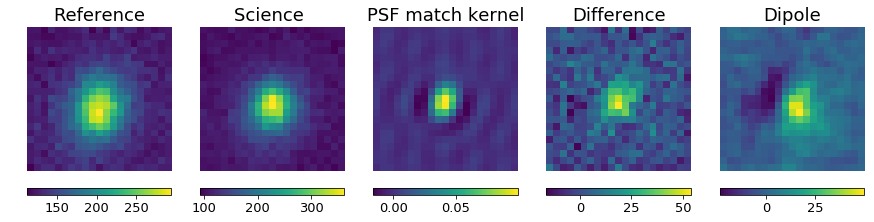

In [20]:
f, ax = plt.subplots(1, 5, figsize=plot_figsize)

image_list = [stamp1, stamp2, kernel, difference_image, wrong_difference_image]
image_title = ["Reference", "Science ", "PSF match kernel", "Difference", "Dipole"]

for i in range(5):
    im = ax[i].imshow(image_list[i])
    cbar = f.colorbar(im, ax=ax[i], orientation='horizontal', pad=0.05)
    cbar.ax.tick_params(labelsize=plot_fontsize-5) 
    ax[i].set_title(image_title[i], fontsize=plot_fontsize)
    ax[i].set_axis_off()
plt.savefig(save_path+"difference_image_example.pdf", bbox_inches = 'tight')
plt.show()